In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6, 7'

In [2]:
import io, base64, pickle, random

import numpy as np
import torch as T

from omegaconf import OmegaConf
from taming.models.vqgan import VQModel

from PIL import Image

Working with z of shape (1, 256, 8, 8) = 16384 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.

flintstones_val_s_03_e_05_shot_037086_037160: Barney is pushing Fred on the stage while talking. Fred is wearing a cape and holding a guitar.


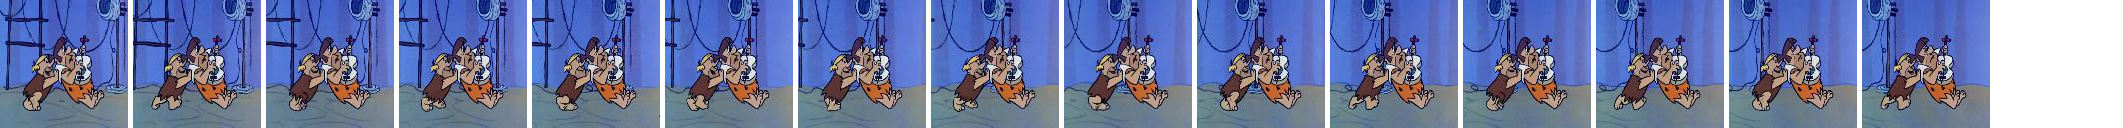

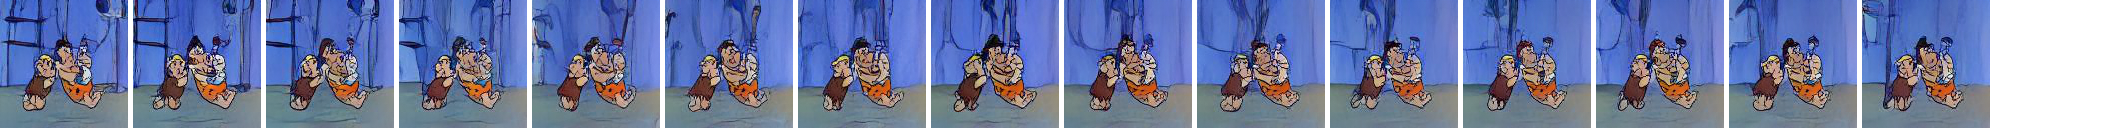


flintstones_val_s_03_e_09_shot_015829_015903: Fred is standing behind a wall on the sidewalk. He is yelling in the distance.


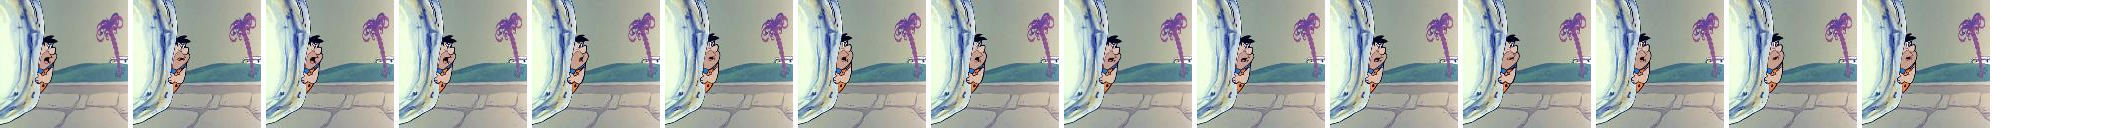

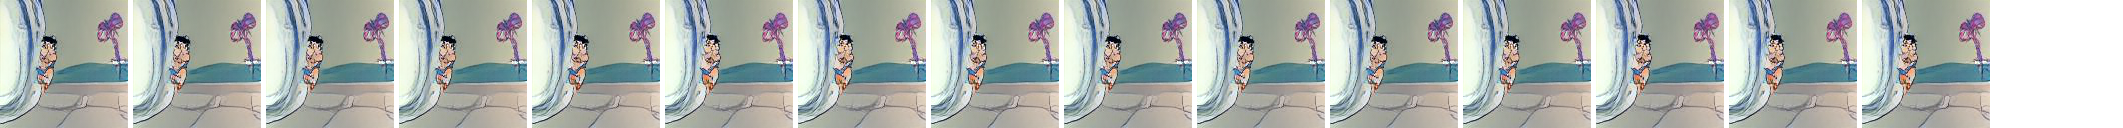


flintstones_val_s_05_e_01_shot_018139_018213: Wilma is in the room, talking to someone off camera left.


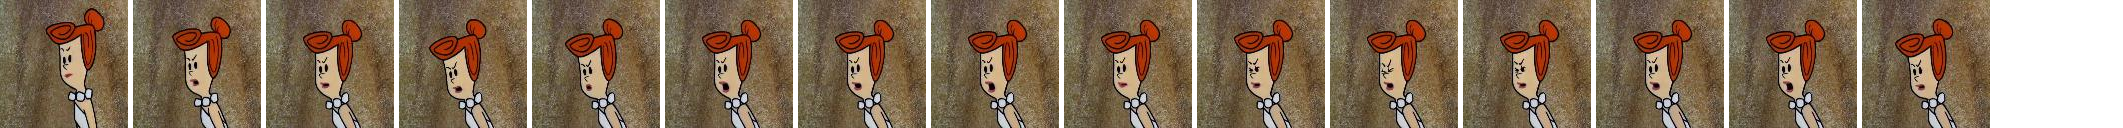

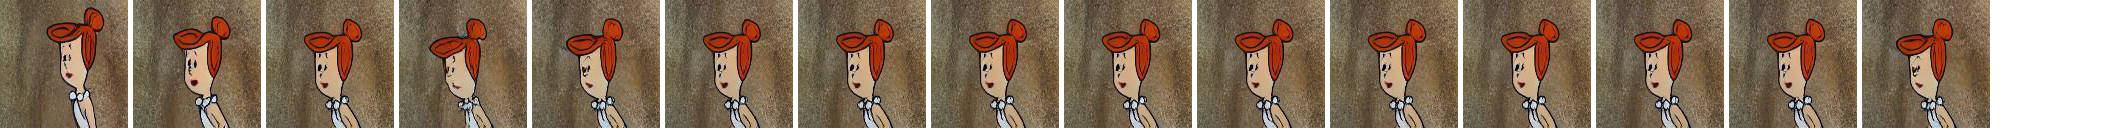

Working with z of shape (1, 256, 8, 8) = 16384 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.

kitchen_val_p04_25_7: open cupboard


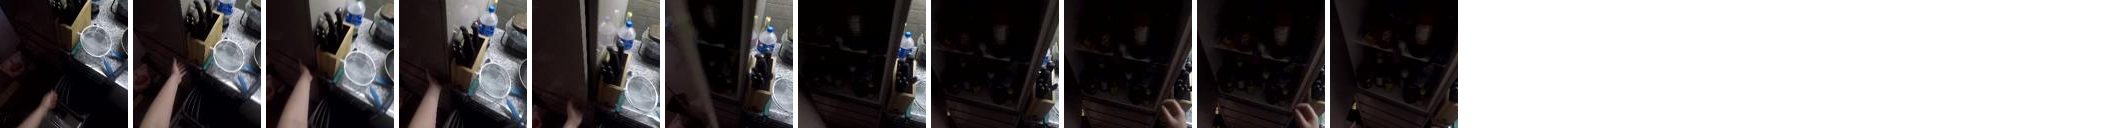

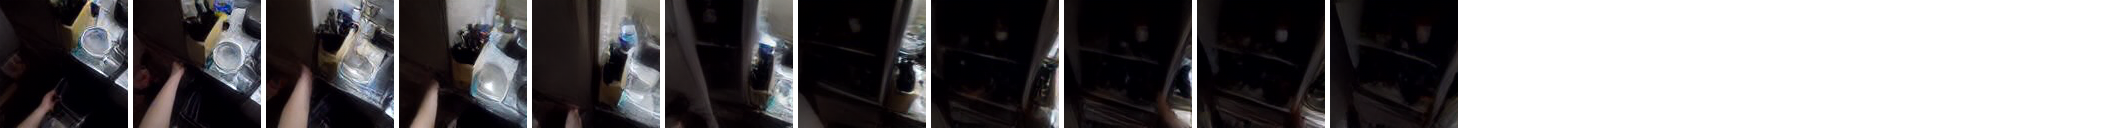


kitchen_val_p01_14_6: open bin


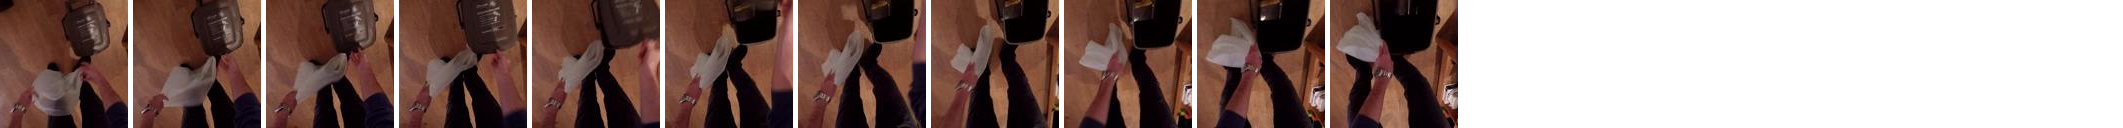

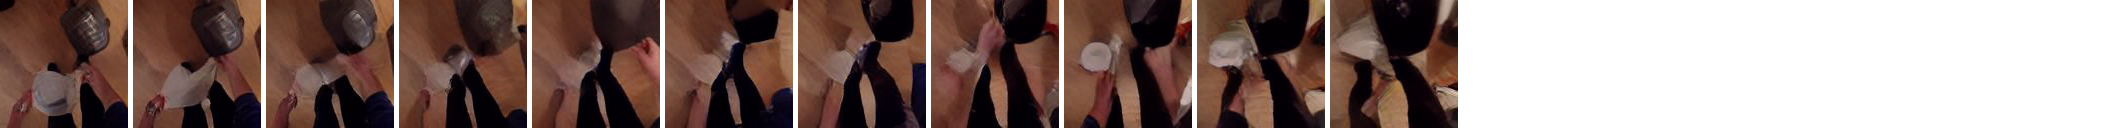


kitchen_val_p24_09_293: adjust flame intensity


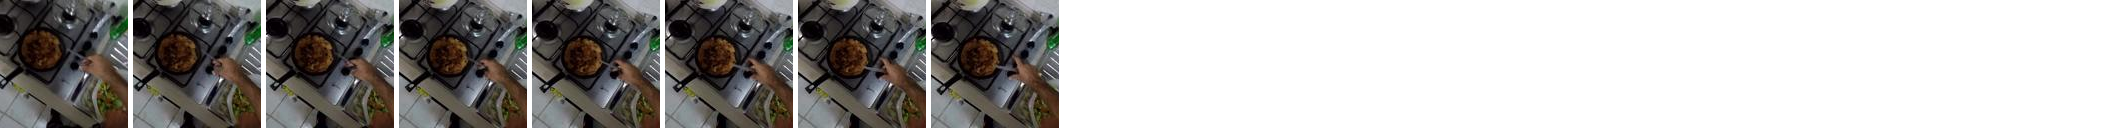

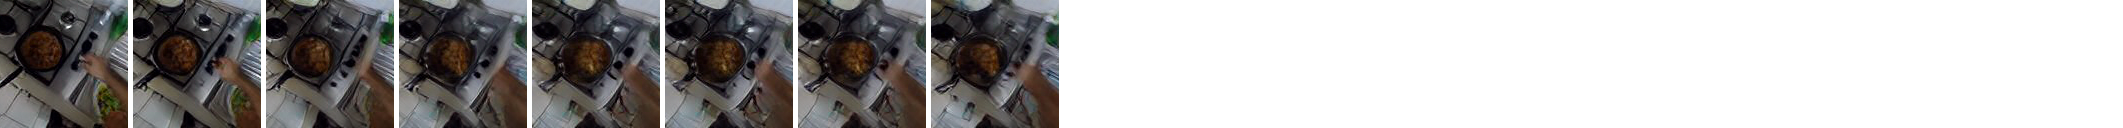

Working with z of shape (1, 256, 8, 8) = 16384 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.

mugen_val_model_gamev2_fine_tune_squat_penalty_die_reward_2.0_seed_710_level_1884_video_frames_0079_to_0174: Mugen runs from left to right ,it jump over a face and coin, it jumped down and up.


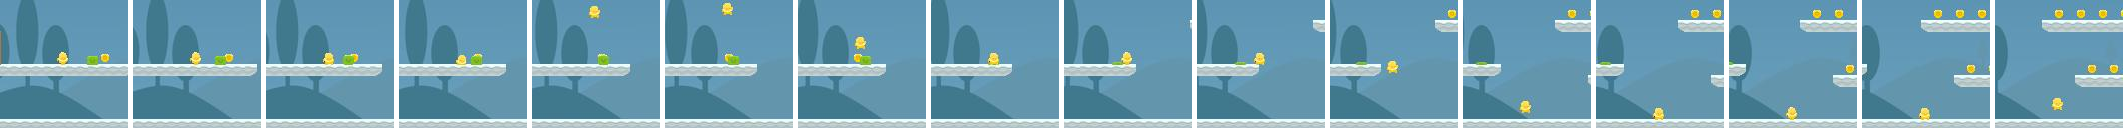

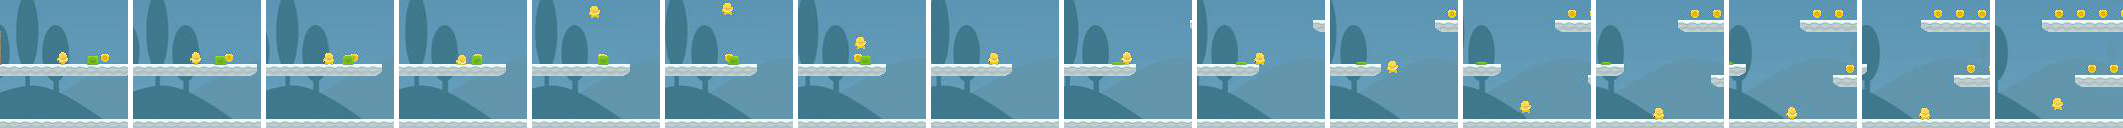


mugen_val_model_gamev2_fine_tune_m4_jump_penalty_seed_607_level_2464_video_frames_0090_to_0185: Mugen lands on a cliff, jumps left to right onto a higher cliff, picks up a gem, moves left to right off the cliff onto a lower cliff, picks up a coin, and dies to a slime.


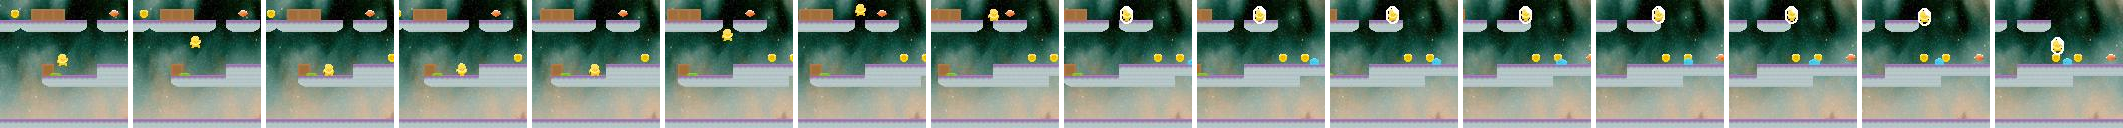

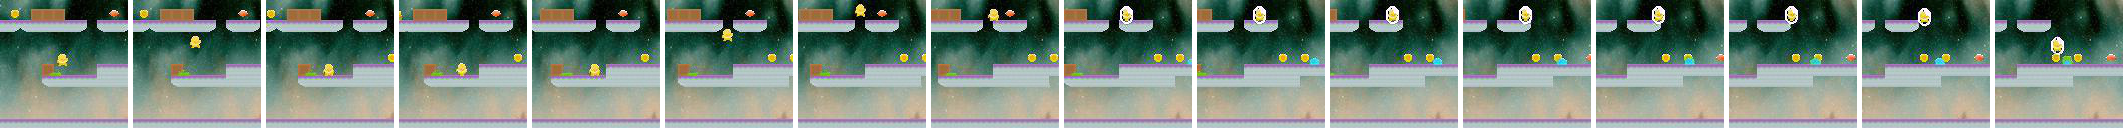


mugen_val_model_gamev2_fine_tune_m4_jump_penalty_2_seed_606_level_0944_video_frames_0006_to_0101: Mugen runs from left to right and jumps up and collect the coin and jumps up and again jumps up and down


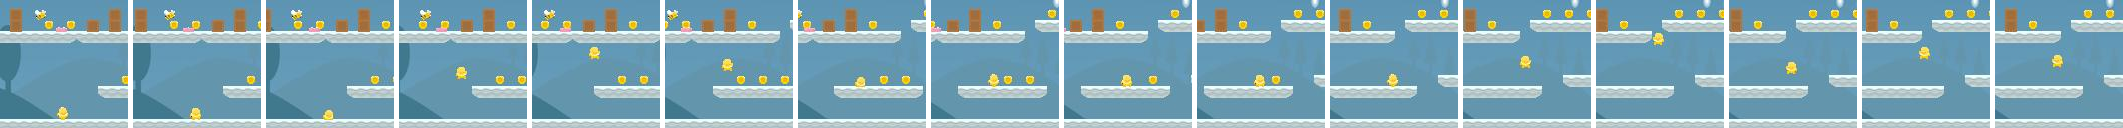

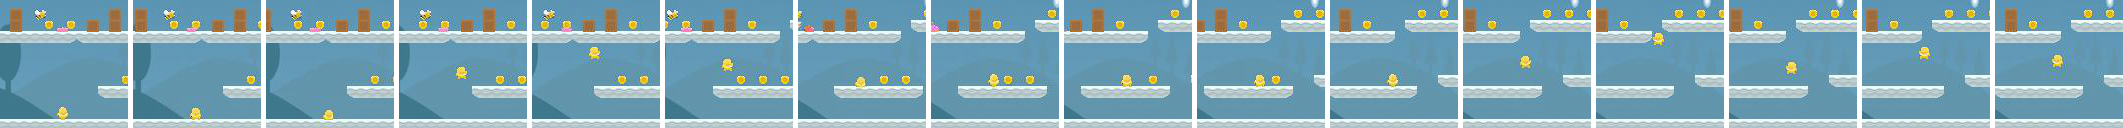

In [3]:
def b2f(b):
    f = Image.open(io.BytesIO(base64.b64decode(b)))
    w, h = f.size
    w, h = int(128*w/h), 128
    f = f.resize([w, h]).crop([(w-128)//2, 0, (w-128)//2+128, 128])
    return f

def lst2img(lst):
    npy = np.ones((128, 128*16+5*15, 3), dtype=np.uint8)*255
    for i, f in enumerate(lst): npy[:, 128*i+5*i:128*i+5*i+128, :] = np.array(f)
    img = Image.fromarray(npy)
    return img

for ds in ['flintstones', 'kitchen', 'mugen']:
    cfg = OmegaConf.load('./_ckpt/yaml_taming_128.yaml')
    VQ = VQModel(**cfg.model.params).eval().cuda()
    _ = VQ.load_state_dict(T.load('./_ckpt/ckpt_taming_%s_128.pt'%(ds), map_location='cpu'))
    
    pkl = pickle.load(open('./_data/%s.pkl'%(ds), 'rb'))
    vids = list(pkl['val'].keys())
    random.shuffle(vids)
    for it in range(3):
        vid = vids[it]
        print('\n%s_val_%s: %s'%(ds, vid, pkl['val'][vid]['text']))
        
        gdt = lst2img([b2f(b) for b in pkl['val'][vid]['video']])
        display(gdt)
        
        with T.no_grad():
            rs = VQ.decode(VQ.quantize.embedding(T.from_numpy(pkl['val'][vid]['vq'].astype(np.int64)).cuda()).permute(0, 3, 1, 2))
            rs = (((rs.permute(0, 2, 3, 1)+1.0)/2.0).clamp(0, 1).cpu().numpy()*255.0).astype(np.uint8)
        rec = lst2img([Image.fromarray(r).convert('RGB') for r in rs])
        display(rec)